(page-spiking)=
# Introduction to spiking systems

Artificial neural networks (as we know them from [PyTorch](https://pytorch.org)) typically consist of linear transformations (such as Convolutions) and point-wise non-linearities such as the rectified linear unit (ReLU). In contrast spiking neural networks take their inspiration from biological
neurons. They operate on spikes - events in time - which are combined by linear transformations and integrated by neuron circuits models, such as the LIF
neuron model. In other words compared to artificial neural networks, where operation on temporal data is a choice, all spiking neural networks operate on
temporal data. One way to look spiking neural networks is to regard them as specific *recurrent neural networks* (RNNs) with the sequence dimension explicitely identified with time and with the values at each timestep that are exchanged between layers restricted to binary values. 

Norse implements state-of-the-art methods to train spiking neural networks in a way that is convenient and accessible to a machine learning researcher.
The eventual goal is to fully explore the sparse information processing of spiking neural networks on neuromorphic hardware. But even if you are not motivated by such application and just curious how information processing can be done by systems whose behaviour is closer to that of biological brains, this 
library might be for you. 

In this page we will cover how to 
1. Simulate neurons
2. Investigate and plot our first spiking neuron


:::{note}
You can execute the code below by hitting <i class="fas fa-rocket"></i> above and pressing <i class="fas fa-play"></i> Live Code.
:::

## Simulating neurons

Neurons consist of two things: the **activation function** and the **neuron membrane state**. To start working with them, we first have to import Norse, aswell as a number of libraries we will use in the course of this notebook.


In [14]:
import matplotlib.pyplot as plt
import torch
import norse
import numpy as np

plt.style.use("../resources/matplotlibrc")
norse.__version__

'0.0.7'

### Defining our first neuron model

One of the simples neuron models, we have added is the [**leaky integrator**](norse/generated/norse.torch.module.leaky_integrator.LI.html). This particular model integrates an input current and on a "membrane" modelled by a *leaky* capacitor. 

In [15]:
activation = norse.torch.LI()
activation

LI(p=LIParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.)), dt=0.001)

### Defining our input spikes

By convention most of our neuron models expect to operate on *input spikes*. In a time discretised setting this is just a sequence of tensors containing binary values. By default we place spikes on a grid spaced by $1 \text{ms}$. So we can define an *input spike sequence* with spikes at $20 \text{ms}$ and
$100 \text{ms}$ and use the Leaky Integrator (LI) to process it, resulting in a *voltage trace*.

In [16]:

data = torch.zeros(1000,1)
data[20] =  1.0
data[100] = 1.0

voltage_trace, _ = activation(data)

### Visualizing neuron voltage

Since this simulation happened over 1000 timesteps (1 second), we expect the model to output the evolution of the membrane potential (the voltage trace), which we can plot, we indicate by red vertical lines the times at which we inject input spikes:

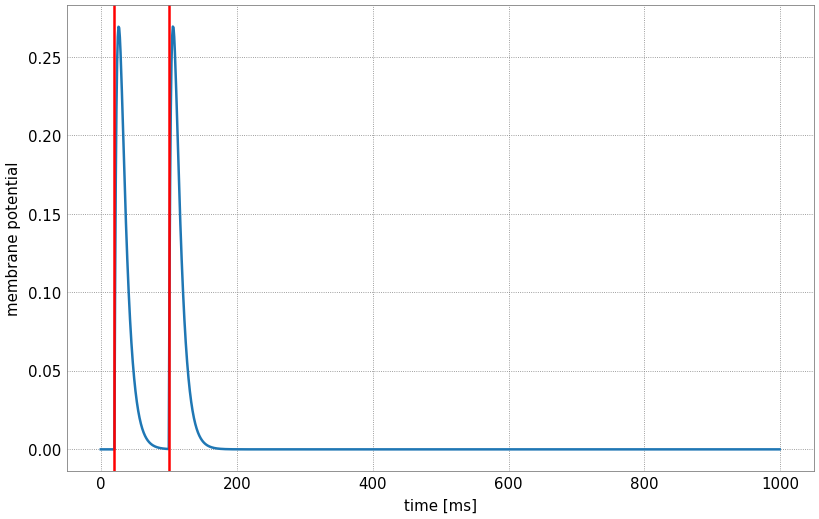

In [17]:
import matplotlib.pyplot as plt

plt.xlabel('time [ms]')
plt.ylabel('membrane potential')
plt.plot(voltage_trace.detach())
plt.axvline(20, color='red')
plt.axvline(100, color='red')

The time course of the membrane potential for this given input is influenced by the parameters passed to the leaky integrator. You can experiment with different values by manipulating the sliders:

In [18]:
import torch
from ipywidgets import interact, IntSlider, FloatSlider
from functools import partial
IntSlider = partial(IntSlider, continuous_update=False)
FloatSlider = partial(FloatSlider, continuous_update=False)


@interact(
    tau_mem=FloatSlider(min=10,max=200,step=1.0, value=10),
    tau_syn=FloatSlider(min=10,max=200,step=1.0, value=20),
    t0=IntSlider(min=0, max=1000, step=1, value=20),
    t1=IntSlider(min=0, max=1000, step=1, value=100),
)
def experiment(tau_mem, tau_syn, t0, t1):
    plt.figure()
    num_neurons = 1
    tau_mem_inv = torch.tensor([1/(tau_mem * 0.001)])
    tau_syn_inv = torch.tensor([1/(tau_syn * 0.001)])
    data = torch.zeros(1000,num_neurons)
    data[t0] =  1.0
    data[t1] = 1.0

    voltage_trace, _ = norse.torch.LI(p=norse.torch.LIParameters(tau_mem_inv=tau_mem_inv, tau_syn_inv=tau_syn_inv))(data)
    plt.xlabel('time [ms]')
    plt.ylabel('membrane potential')
    for i in range(num_neurons):
        plt.plot(voltage_trace.detach()[:,i])
    plt.axvline(t0, color='red', alpha=0.9)
    plt.axvline(t1, color='red', alpha=0.9)
    plt.show()

interactive(children=(FloatSlider(value=10.0, continuous_update=False, description='tau_mem', max=200.0, min=1…

As you can see as the membrane time constant $\tau_\text{mem}$ is increased (and consequentely its inverse decreased), the decay of the membrane voltage is slower, but it also reaches a smaller value. The value of the synaptic time constant $\tau_\text{syn}$ in turn influences how quickly the synaptic input decays exponentially

## Our first Spiking Neuron

Spikes that stimulate a neuron in close succession lead to an increasingly higher membrane potential, which is in some sense the foundational principle of information processing with spiking neurons: If one replaces the Leaky Integrator with a Leaky Integrate and *Fire* neuron model (```LIF```) one arrives at the simplest *spiking* neuron model implemented in Norse. Since we only return the spike train produced by a ```LIF``` neuron by default we define a simple helper function first, which also records the voltage trace. To do so we use the ```LIFCell``` module, which only computes the state evolution for one timestep. 

In [19]:
def integrate_and_record_voltages(cell):
    def integrate(input_spike_train):
        T = input_spike_train.shape[0]
        s = None
        spikes = []
        voltage_trace = []
        for ts in range(T):
            z, s = cell(input_spike_train[ts], s)
            spikes.append(z)
            voltage_trace.append(s.v)
        return torch.stack(spikes), torch.stack(voltage_trace)
    return integrate

By repeating the same experiment, that is stimulating the ```LI``` and ```LIF``` neuron with spikes at $20, t_0, t_1$ milliseconds, we immediately see the difference: Once the LIF neuron reaches its threshold value $v_\text{th}$ it *fires* resulting in an output spike and a reset of its membrane voltage to $0$. The output spike train produced by a ```LIF``` neuron could be used for further processing by other neurons.

In [20]:
@interact(
    tau_mem=FloatSlider(min=10,max=200,step=1.0, value=40),
    tau_syn=FloatSlider(min=10,max=200,step=1.0, value=60),
    v_th=FloatSlider(min=0.1, max=2.0, step=0.1, value=0.8),
    t0=IntSlider(min=0, max=1000, step=1, value=85),
    t1=IntSlider(min=0, max=1000, step=1, value=150),
)
def experiment(tau_mem, tau_syn, v_th, t0, t1):
    plt.figure()
    num_neurons = 1
    tau_syn_inv = torch.tensor([1/(tau_syn * 0.001)])
    tau_mem_inv = torch.tensor([1/(tau_mem * 0.001)])
    data = torch.zeros(1000,num_neurons)
    data[20] = 1.0
    data[t0] = 1.0
    data[t1] = 1.0

    cell = norse.torch.LIFCell(p=norse.torch.LIFParameters(tau_mem_inv=tau_mem_inv, tau_syn_inv=tau_syn_inv, v_th=torch.as_tensor(v_th)))
    lif_integrate = integrate_and_record_voltages(cell)

    voltage_trace, _ = norse.torch.LI(p=norse.torch.LIParameters(tau_mem_inv=tau_mem_inv, tau_syn_inv=tau_syn_inv))(data)
    zs, lif_voltage_trace = lif_integrate(data)
    plt.xlabel('time [ms]')
    plt.ylabel('membrane potential')
    plt.plot(voltage_trace.detach(), label="LI")
    plt.plot(lif_voltage_trace.detach(), label="LIF")
    plt.axhline(v_th, color='grey')
    plt.legend()
    plt.show()

interactive(children=(FloatSlider(value=40.0, continuous_update=False, description='tau_mem', max=200.0, min=1…